In [1]:
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import nltk
from nltk import pos_tag
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 90

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
df = pd.read_csv('tweet_list2.csv')
for n in df.columns:
    df[n] = df[n].astype(str)
df.dtypes
df.info()
df['user_name'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115511 entries, 0 to 115510
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_name   115511 non-null  object
 1   class       115511 non-null  object
 2   id          115511 non-null  object
 3   text        115511 non-null  object
 4   author_id   115511 non-null  object
 5   created_at  115511 non-null  object
dtypes: object(6)
memory usage: 5.3+ MB


WSJbusiness        1606
NatGeo              850
markets             850
ScienceMagazine     850
ReutersBiz          850
                   ... 
repvalhoyle          10
JMoylanforGuam       10
NBCNetwork            7
RepJeffJackson        2
DNC                   1
Name: user_name, Length: 586, dtype: int64

Check for duplicates

In [3]:
df.duplicated()

0         False
1         False
2         False
3         False
4         False
          ...  
115506    False
115507    False
115508    False
115509    False
115510    False
Length: 115511, dtype: bool

Drop duplicates

In [4]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114634 entries, 0 to 115510
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_name   114634 non-null  object
 1   class       114634 non-null  object
 2   id          114634 non-null  object
 3   text        114634 non-null  object
 4   author_id   114634 non-null  object
 5   created_at  114634 non-null  object
dtypes: object(6)
memory usage: 6.1+ MB


Check class balance

In [5]:
df['class'].value_counts()

Politics - Conservative    31032
Politics - Liberal         26998
TV / movies                12007
Sports                     12000
Music                      11600
Business and finance        8452
Science / Technology        7550
Travel                      4995
Name: class, dtype: int64

Pre-processing

Data transformation functions

In [6]:
def strip_rt_user(text):
    if text[0:2] == "RT":
        colon = text.find(":")
        return text[colon+1:].lower()
    else:
        return text.lower()

def get_rt_user(text):
    if text[0:2] == "RT":
        colon = text.find(":")
        user = text[:colon]
        at = user.find("@")
        return (user[at+1:]).lower()
    else:
        return ""

def addHashTags(text):
    return "#" + text + "#"
    
def strip_links(text):
    tokens = text.split()
    
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def remove_characters(text, char_to_remove):
    str1 = ''.join(x for x in text if not x in char_to_remove)
    return str1

def remove_punctuation(text):
    text = remove_characters(text, string.punctuation)
    return text


In [7]:
df

,user_name,class,id,text,author_id,created_at
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00
3,BennieGThompson,Politics - Liberal,1620116109864357888,https://t.co/Ze7ePCUJJ2,82453460,2023-01-30 17:45:55+00:00
4,BennieGThompson,Politics - Liberal,1620061909113516036,https://t.co/ley5hNsz0y https://t.co/RFdTeGXGO1,82453460,2023-01-30 14:10:33+00:00
...,...,...,...,...,...,...
115506,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00
115507,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00
115508,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00
115509,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00


In [8]:
df2 = df.copy()
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

# Constants 
min_word_size = 4
min_word_count = 3

# Make special user names and retweet names, and pull it out from the text tweet
df2['text2'] = df2['text'].apply(strip_rt_user)
df2['RT_user'] = df2['text'].apply(get_rt_user)
df2['RT_user#'] = df2['RT_user'].apply(lambda x: addHashTags(x) if x != "" else "")

# Lower case the text tweets
df2['text2'] = df2['text2'].str.lower()

# Strip out the meaningless links
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n[0:4] != "http"]))

# Strip any excess white space
df2['text2'] = df2['text2'].apply(lambda x: x.strip())

# Take out stop words
sw = set(stopwords.words('english'))
sw.update(['amp'])
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n not in sw]))

# Remove punctuation
df2['text2'] = df2['text2'].apply(lambda x: remove_punctuation(x))

# min length of characters for word
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if len(n) >= min_word_size]))

# Make sure we don't have any random numbers
df2['text2'] = df2['text2'].apply(lambda x: " ".join([n for n in x.split() if n.isnumeric() == False]))

# Stem the words
sb = SnowballStemmer(language='english')
df2['text2'] = df2['text2'].apply(lambda x: " ".join([sb.stem(n) for n in x.split()]))

# Put it all together in a new column
df2['text2'] = df2['text2'] + " " + df2['RT_user#']

# Limit data to tweets that have greater than specific number of words
df2['word_count'] = df2['text2'].apply(lambda x: len(x))
df2 = df2[ df2['word_count'] >= min_word_count ]

# Make a new column, tokenize the words
df2['text3'] = df2['text2'].str.split()

# Make a new df
df3 = df2.copy()
df3['text3'] = df3['text3'].apply(lambda x: np.nan if len(x) == 0 else x)
df3 = df3.dropna().reset_index(drop=True) 
df3





,user_name,class,id,text,author_id,created_at,text2,RT_user,RT_user#,word_count,text3
0,BennieGThompson,Politics - Liberal,1620584010991939584,"Today marks the 83rd anniversary of the first ever #SocialSecurity check, and Republic...",82453460,2023-02-01 00:45:11+00:00,today mark 83rd anniversari first ever socialsecur check republican celebr tri vital p...,,,156,"[today, mark, 83rd, anniversari, first, ever, socialsecur, check, republican, celebr, ..."
1,BennieGThompson,Politics - Liberal,1620116251749269511,RT @VP: President Biden and I are just getting started. https://t.co/gLmNbpKGAN,82453460,2023-01-30 17:46:29+00:00,presid biden get start #vp#,vp,#vp#,27,"[presid, biden, get, start, #vp#]"
2,BennieGThompson,Politics - Liberal,1620116182618759168,"RT @RepJeffries: We will never negotiate away the health, safety or economic well-bein...",82453460,2023-01-30 17:46:12+00:00,never negoti away health safeti econom wellb american peopl #repjeffries#,repjeffries,#repjeffries#,73,"[never, negoti, away, health, safeti, econom, wellb, american, peopl, #repjeffries#]"
3,BennieGThompson,Politics - Liberal,1619330126361300993,The footage of Tyre Nichols killing is painful. I send my condolences to his family an...,82453460,2023-01-28 13:42:42+00:00,footag tyre nichol kill pain send condol famili friend justic must serv respons,,,80,"[footag, tyre, nichol, kill, pain, send, condol, famili, friend, justic, must, serv, r..."
4,BennieGThompson,Politics - Liberal,1619327606159179777,RT @CBCInstitute: Happy Birthday to our Chairman Congressman @BennieGThompson! In your...,82453460,2023-01-28 13:32:41+00:00,happi birthday chairman congressman benniegthompson 30th congress celebr incred #cbcin...,cbcinstitute,#cbcinstitute#,94,"[happi, birthday, chairman, congressman, benniegthompson, 30th, congress, celebr, incr..."
...,...,...,...,...,...,...,...,...,...,...,...
112412,RepLCD,Politics - Conservative,1611786100825006080,It was great to catch up with my friend @RepFeenstra last night -- we're ready to get ...,1583530102297600000,2023-01-07 18:05:26+00:00,great catch friend repfeenstra last night were readi work deliv promis made american p...,,,101,"[great, catch, friend, repfeenstra, last, night, were, readi, work, deliv, promis, mad..."
112413,RepLCD,Politics - Conservative,1611615029660639233,Thank you #OR05 for placing your trust in me to represent you in the halls of Congress...,1583530102297600000,2023-01-07 06:45:40+00:00,thank or05 place trust repres hall congress solemn promis oregonian carri constitut du...,,,128,"[thank, or05, place, trust, repres, hall, congress, solemn, promis, oregonian, carri, ..."
112414,RepLCD,Politics - Conservative,1610791524807081986,A small minority is preventing the House from doing the work we were sent here to do. ...,1583530102297600000,2023-01-05 00:13:21+00:00,small minor prevent hous work sent must economi back track work cost live control impr...,,,130,"[small, minor, prevent, hous, work, sent, must, economi, back, track, work, cost, live..."
112415,RepLCD,Politics - Conservative,1610408428052295681,"As I take on the responsibility of serving #OR05, I'm very grateful to have my family ...",1583530102297600000,2023-01-03 22:51:03+00:00,take respons serv or05 grate famili side,,,41,"[take, respons, serv, or05, grate, famili, side]"


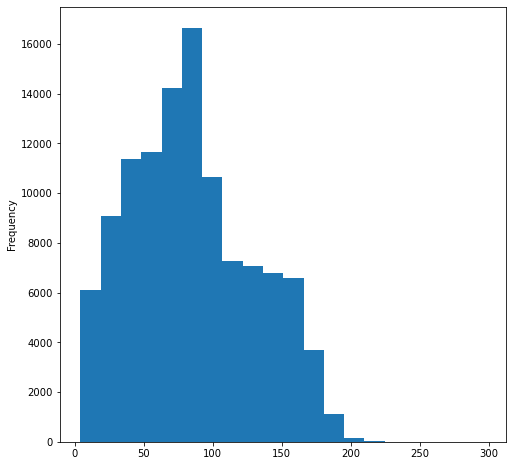

In [10]:
ax = df3['word_count'].plot.hist(figsize=(8,8), bins=20)

First try to predict Political affiliation.  Then move on to the others.

In [11]:
df3 = df3[(df3['class'] == 'Politics - Conservative') | (df3['class'] == 'Politics - Liberal')]
# df3

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df3['class_label'] = le.fit_transform(df3['class'])

<ipython-input-12-adeaad1ad0a3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['class_label'] = le.fit_transform(df3['class'])


In [13]:
labels = df3.groupby(['class', 'class_label'])['class',].count()
labels

,,class
class,class_label,
Politics - Conservative,0,30453
Politics - Liberal,1,26824


In [14]:
X = df3['text3']
y = df3['class_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.65, stratify=y)

In [15]:
X_train

9554      [ernest, hemingway, third, child, identifi, gregori, obituari, wikipedia, call, gloria...
12328     [rememb, kevin, mccarthi, lost, speaker, admit, public, sole, purpos, benghazi, select...
17058                                      [person, tax, paid, briton, surg, remark, financi, year]
15176     [guest, alert, kentucki, senat, randpaul, join, show, today, tune, listen, here, #clay...
15773                                             [christma, american, everyth, tree, tree, itself]
                                                    ...                                            
5445      [long, past, time, action, kind, action, anoth, tragedya, quieter, less, tragic, onefo...
104654    [comer, press, hunter, biden, dealer, communic, white, hous, request, interview, news,...
111808    [thank, thousand, prolif, nebraskan, turn, bitter, cold, morn, togeth, inspir, neighbo...
7306      [hous, republican, priorit, protect, rich, cheat, allow, less, tax, middleclass, ameri...


In [16]:
# Import the relevant vectorizer class
from sklearn.feature_extraction.text import TfidfVectorizer

def dummy_fun(doc):
    return doc

# Instantiate a vectorizer with max_features=10
# (we are using the default token pattern)
tfidf = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, max_features=8000)

# Fit the vectorizer on X_train["text"] and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

# Visually inspect the vectorized data
# pd.DataFrame.sparse.from_spmatrix(X_train_vectorized, columns=tfidf.get_feature_names())

First try a Naive Bayes Classifier

In [17]:
# Import relevant class and function
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

0.7994117723899282

In [18]:
# Fit the vectorizer on X_train["text"] and transform it
X_test_vectorized = tfidf.transform(X_test)

# Visually inspect the vectorized data
# pd.DataFrame.sparse.from_spmatrix(X_test_vectorized, columns=tfidf.get_feature_names())

In [19]:
# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_test_vectorized, y_test)
baseline_cv.mean()

0.7982056420118593

Random Forest Classifier

In [20]:
# Import relevant class and function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Instantiate a MultinomialNB classifier
baseline_model = RandomForestClassifier(max_depth=100)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv.mean()

array([0.7436409 , 0.7380893 , 0.73409828, 0.75130955, 0.72437017])

In [21]:
# Fit the vectorizer on X_train["text"] and transform it
X_test_vectorized = tfidf.transform(X_test)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_test_vectorized, y_test)
baseline_cv.mean()

0.7553917574063809

XGBoost Classifier

In [ ]:
import xgboost as xgb

baseline_model = xgb.XGBClassifier(random_state=42)
baseline_cv = cross_val_score(baseline_model, X_train_vectorized, y_train)
baseline_cv

In [ ]:
# Fit the vectorizer on X_train["text"] and transform it
X_test_vectorized = tfidf.transform(X_test)

# Evaluate the classifier on X_train_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, X_test_vectorized, y_test)
baseline_cv.mean()